# 1. Introduction

Today time series forecasting is ubiquitous, and decision-making processes in companies depend heavily on their ability to predict the future. Through a short series of articles I will present you with a possible approach to this kind of problems, combining state-space models with Bayesian statistics.

In the initial articles, I will take some of the examples from the book *An Introduction to State Space Time Series Analysis* from Jacques J.F. Commandeur and Siem Jan Koopman [1]. It comprises a well-known introduction to the subject of state space modeling applied to the time series domain.

My contributions will be:

* A very humble attempt to close the gap between these two fields in terms of introductory and intermediate materials.
* The presentation of concepts: on the one hand, a concise (not non-existent) mathematical basis to support our theoretical understanding and, on the other hand, an implementation from scratch of the algorithms (whenever possible, avoiding “black box” libraries). In my opinion, it is the best way to make sure that we can grasp an idea.
* The proper implementation of the proposed models using PyMC3 as well as their interpretation and discussion.

This post belongs to a series, feel free to check the previous post to acquire some more context:
1. [The First Step in Bayesian Time Series— Linear Regression](https://towardsdatascience.com/the-first-step-in-bayesian-time-series-linear-regression-89a64b826a7e)

# 2.  Our first state space model

As promised, we will be defining our first state space model in this article, the *deterministic level model*. It is the simplest one that we could possibly design. So simple that we can't solve any real problem with it. But, it is a *state space model*, nevertheless. It belongs to the *local level models* bucket of the *state space models*. As the name indicates, in this model there is one component of the state that we will focusing on: the *level*. In our current context the *level* is equivalent to what an intercept is for a linear regression. This is why we call it *deterministic*, it means that the level is static - i.e. applied globally to all time points.

It can be defined as

$$Y_t = \mu_1 + \epsilon_t, \quad \epsilon_t \sim NID(0, \sigma_\epsilon^2)$$

for $t = 1,...,n$. We can see that everything is dependent on the level value when $t=1$, keeping it constant for all $t$. The observation disturbance is denoted by $\epsilon_t$ (or sometimes referred as irregular component) at time $t$.

Let's code it in two ways, using the standard approach and then using a bayesian approach.

## 2.1. Classical implementation

Can we implement this by hand? We should get an intuition first on what are we exactly doing. This is a great opportunity because our problem is quite simple.

We need to do a quick (probably not the quickest) detour to get this one.

### 2.1.1. Maximum likelihood estimation

This is a very important concept, mathematically can become complex but it is quite intuitive to grasp. The *maximum likelihood estimation (MLE)* is a method that allows us to estimate the parameters of the probability distribution that generated a specific sample of data (for us, it is our time series). Probably you should read again the last sentence.

We are going to work on a specific case, the one that we are interested in, the MLE for a *Gaussian* (or Normal) distribution.

A Gaussian is a *continuous probability distribution*, the very well known bell shaped distribution. We use probability density functions (usually written as pdf) to define it. The distribution is completely described with two parameters, the mean ($\mu$) and the variance ($\sigma^2$). We can write it as,

$$ 
f(X; \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\big [{-\frac{(x-\mu)^2}{2\sigma^2} }\big ]
$$

The parameters are defined after the semicolon.

Let's plot it with different combinations of the parameters.

In [ ]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pymc3 as pm
import arviz as az
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import acf, plot_acf
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

ukdrivers = np.genfromtxt('./data/UKdriversKSI.txt', skip_header=True)
y = np.log(ukdrivers)
t = np.arange(1,len(y)+1)

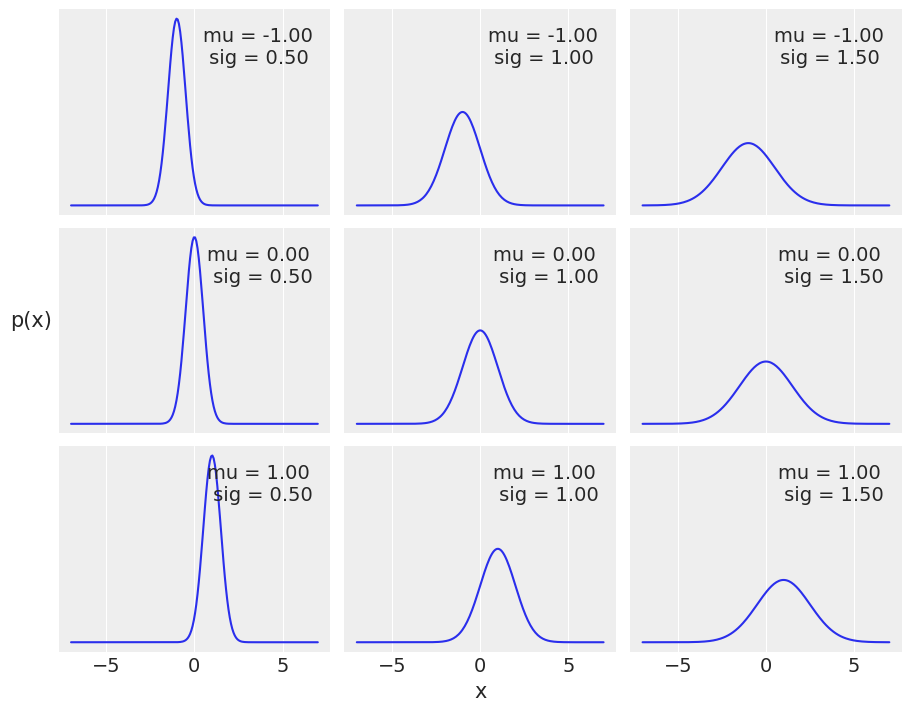

In [4]:
mu_params = [-1,0,1]
sd_params = [0.5, 1, 1.5]

x = np.linspace(-7,7,200)

_,ax = plt.subplots(len(mu_params), len(sd_params), sharex=True,
                   sharey=True, figsize=(9,7), constrained_layout=True)

for i in range(3):
    for j in range(3):
        mu=mu_params[i]
        sd=sd_params[j]
        y = stats.norm(mu, sd).pdf(x)
        ax[i, j].plot(x,y)
        ax[i,j].plot([], label="mu = {:3.2f}\n sig = {:3.2f}".format(mu, sd), alpha=0)
        ax[i,j].legend(loc=1)
        ax[2,1].set_xlabel('x')
        ax[1,0].set_ylabel('p(x)', rotation=0, labelpad=20)
        ax[1,0].set_yticks([])

Now that we saw the different bell curves that we can create with just two parameters, we have an increadible flexible power at hand to model real processes. We are just lacking the ability to estimate what the best two parameters that generated a specific sample of data are. We need some math to do it.

To avoid confusion let's work on the notation first. This is a frequentist method by nature. You will often find a semicolon instead of a vertical bar | to denote that we are conditioning on the parameters. In the classical perspective, our $\mu$ and $\sigma$ are unknown parameters and not random variables. If we were using our bayesian hats (which we are), we would use the vertical bar, because our parameters become true random variables. This gives us consistency and also makes it simpler to understand.

More on notation. We will often use $\theta$ to define a set of parameters. It could represent $\mu$ and $\sigma$ when defining a gaussian distribution. 

Having that in mind, we need to be precise on differentiating $P(Y|\theta)$ from $P(\theta|Y)$. The first is the likelihood and the later is the posterior and they can be very different. We saw this in Bayes theorem but we need to sharp our eyes to spot the differences.

Let's read $P(Y|\theta)$: it is the probability of our time series Y (our data) given that our parameters are equal to $\theta$.

Having the notation defined, we are going to focus on... the name. The MLE is the *maximum* likelihood estimation, so we to maximize something. In fact, the MLE for $\theta$ is the value of $\theta$ that maximizes the likelihood $P(Y|\theta)$. 

Now, we need to assume two things: that our observations are *identical and independently distributed*. The identical part is quite self-explanatory, as we want to describe them with just one distribution. The independence part is which allow us to use an important property: their joint pdf is the product of the individual pdf's. Nevertheless, this is obviously not the case for our problem. Our points clearly depend on one another. Nevertheless, things get quite messy if we don't use this assumption, so bear with me for now. We are just building intuition on what is happening.

We are ready to define it

$$\begin{aligned}
L = f(Y|\theta) &= f(y_1|\theta) f(y_2|\theta),..., f(y_n|\theta) \\
&= \prod^n_{j=1}f(Y| \mu,\sigma^2) \\
&= (2\pi\sigma^2)^{-n/2} \exp{\big(-\frac{1}{2\sigma^2} \sum^n_{j=1}(y_i-\mu)^2\big)}
\end{aligned}$$

We now get to a new problem, multiplying many small probabilities together can be numerically unstable. To overcome this, we can use the log of the same function. The natural logarithm is a monotonically increasing function, which means that if the value on the x-axis increases, the value on the y-axis also increases. This is important because it ensures that the maximum value of the log of the probability occurs at the same point as the original probability function. It does another very conveniently thing for us, it transforms our products into sums.

Let's perform the transformation

$$\begin{aligned}
\log(L(Y|\theta)) &= \log\big((2\pi\sigma^2)^{-n/2} \exp{\big(-\frac{1}{2\sigma^2} \sum^n_{j=1}(y_i-\mu)^2\big)\big)} \\
&= -\frac{n}{2}\log(2\pi)-\frac{n}{2}\log(\sigma^2)-\frac{1}{2\sigma^2}\sum_{j=1}^{n}(y_i-\mu)^2
\end{aligned}$$

Almost there! We will now work our optimization problem at hand. We can put it as simple as

$$\max_{\mu,\sigma^2}\log(L(Y|\theta))$$

The expression derived above can be differentiated to find the maximum. Expanding our parameters we have $\log(L(Y|\mu, \sigma))$. As it is a function of the two variables $\mu$ and $\sigma$ we use partial derivatives to find the MLE. 

Starting with $\hat \mu$ (the hat indicates that it is an estimator, i.e. our output), we compute it from

$$\begin{aligned}
& \quad \frac{\partial}{\partial \mu} \log(L(Y|\mu, \sigma)) \\
&= \frac{\partial}{\partial \mu} \big(-\frac{n}{2}\log(2\pi)-\frac{n}{2}\log(\sigma^2)-\frac{1}{2\sigma^2}\sum_{j=1}^{n}(y_i-\mu)^2\big)
\\
&= \sum^n_{j=1} \frac{(y_i - \mu)}{\sigma^2}
\end{aligned}$$

Setting the expression above equal to zero we get


$$\sum^n_{j=1} \frac{(y_i - \mu)}{\sigma^2} = 0 $$

Then
$$\begin{aligned}
\hat\mu &= \frac{\sum^n_{j=1}y_i}{n} \\
\hat\mu &= \bar y
\end{aligned}$$

Surprisingly or not (hope it wasn't) this is the mean of the data! We do exactly the same thing for $\sigma$. I'm going to cut some steps.

$$\frac{\partial}{\partial \sigma} \log(L(Y|\mu, \sigma)) = 0 $$

Which results in 

$$\hat \sigma^2 = \frac{\sum^n_{j=1}(y_i - \hat \mu)^2}{n}$$



And finally, by using the value of $\hat \mu$, we get


$$\hat \sigma^2 = \frac{\sum^n_{j=1}(y_i - \bar y)^2}{n}$$

Strangely of not this is the variance of the data. So much work to get the mean and variance of the data! They are the best estimators for our data... obviously! But now you got the feeling on why mathematically this is. 

Just one more ah ah moment. We already saw in the last post the least-squares method to estimate our parameters of a linear regression. It turns out that when the model is assumed to be Gaussian as in the examples above, the MLE estimates are equivalent to the least-squares method.

Not getting into the math we can grasp the idea. In the case of the least squares parameter estimation we want to find the line that minimises the total squared distance between the data points and the regression line. On the other hand, in the maximum likelihood estimation we want to maximise the total probability of the data. When a Gaussian distribution is assumed, the maximum probability is found when the data points get closer to the mean value. Since the Gaussian distribution is symmetric, this is equivalent to minimising the distance between the data points and the mean value.

### 2.1.2. Maximum a Posteriori and Bayes Theorem

We discussed the Bayes Theorem in the last post, now it is time to connect it to a new concept. *The Maximum a Posteriori* (MAP) is the bayesian equivalent to the MLE. 

Just to remind ourselves, we have the Bayes Theorem bellow.

$$P(A \mid B) = \frac{P(B \mid A)\, P(A)}{P(B)}$$


In the equation above $B$ is the *evidence*, $p(A)$ is the *prior*, $p(B \mid A)$ is the *likelihood*, and $p(A \mid B)$ is the *posterior*. $P(A \mid B)$ is the probability of $A$ happening *if* $B$ happened. One side note, the equation works not only for probabilities but also with probability distributions (more important to us). 

In reality for now let's forget about probabilities and distributions as we are just focused on optimizing a quantity.

$$P(A \mid B) \propto P(B \mid A)\, P(A)$$

This means that $P(A \mid B)$ is proportional to $P(B \mid A)\, P(A)$, i.e. $P(B)$ is a normalizing constant and we don't need to normalize our result. In fact this is hardest component to compute in Bayes equation and we will see more about it in the future.

Let's adapt the equation to our problem.

$$p(\theta \mid Y) = \frac{p(Y \mid \theta) p(\theta)}{p(Y)} \propto P(Y \mid \theta)\, P(\theta)$$

Quite similar to what we saw earlier working our the MLE example. We have one additional element: $P(\theta)$. This is our prior knowledge about our parameters and one fundamental idea behind Bayesian statistics. In the MLE case, we were implicitly assuming that all values of our parameters $\mu$ and $\sigma$ were equally likely, i.e. we didn't have any information to start with. This is the real difference between MLE and MAP. MLE assumes that all solutions are equally likely beforehand. MAP, on the other hand, allows us to accomodate prior information on our calculations. If we define the MAP with a flat prior, then we are basically doing MLE.

## 2.2. Raw implementation

It wasn't a very quick detour but we got somewhere. Let's see where we are right now. We know that state space models maximize a log-likelihood function and we saw how it is defined as well as two different procedures to do this maximization. Using the MLE we get two estimators, $\hat \mu$ and $\hat \sigma$. Let's calculate these estimators for our problem.

In [6]:
y = np.log(ukdrivers)
μ_hat = y.mean()
σ_sq_hat = np.var(y)

print(f'μ_hat = {μ_hat:.4f}\nσ_sq_hat = {σ_sq_hat:.4f}')

μ_hat = 7.4061
σ_sq_hat = 0.0292


Almost there. Just a small note on the $\hat \sigma$ value. Let's run the same model with a library that has everything set up for us. We will go through that code, but I need you to see something.

In [53]:
import statsmodels.api as sm
model_ll = sm.tsa.UnobservedComponents(y, 
                                       level=True)
model_fit = model_ll.fit()
σ_sq_hat = model_fit.params[0]
print(np.round(σ_sq_hat,5))

0.02935


We are not getting the same result. This happens because NumPy uses by default one formula to compute the variance but in fact we should use another.

The one that NumPy uses is 

$$\frac{1}{n} \sum^n_{t=1}{(y_t-\bar y)^2}$$

The one that we should use is

$$\frac{1}{n-1} \sum^n_{t=1}{(y_t-\bar y)^2}$$

For small sample sizes our estimator is unlikely to perfectly represent the data. Using this normalization term is a way of reducing the bias on our estimator. Let's implement the latter.

In [11]:
print(np.round(np.sum((y-y.mean())**2)/(len(y)-1),5))
# or
print(np.round(np.var(y, ddof=1),5))

0.02935
0.02935


We got to the same result.

Now what? 

Well, believe it or not, we have our *deterministic level* equation.

$$Y_t = 7.4061 + \epsilon_t, \quad \epsilon_t \sim NID(0, 0.02935)$$

Exciting news! 

## 2.3. `statsmodel` implementation

It makes sense to see how can we implement the deterministic level model with two lines of code using a library such as `statsmodels`.

In [18]:
model_ll = sm.tsa.UnobservedComponents(y, 
                                       level=True)
model_fit = model_ll.fit()

print(model_fit.summary())

                          Unobserved Components Results                           
Dep. Variable:                          y   No. Observations:                  192
Model:             deterministic constant   Log Likelihood                  63.314
Date:                    Wed, 25 Nov 2020   AIC                           -124.628
Time:                            16:24:36   BIC                           -121.375
Sample:                                 0   HQIC                          -123.310
                                    - 192                                         
Covariance Type:                      opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0294      0.003      8.987      0.000       0.023       0.036
Ljung-Box (Q):                      637.74   Jarque-Bera (JB):                 0.

In [20]:
model_fit.level['smoothed'][0]

7.406107601964578

As simple as that we have our model fitting the data. We can see our two parameters sigma2.irregular ($\epsilon_t$) and the level component $\mu_1$. We also get a lot of statistical tests that we will learn about in the future.

# 3. The Bayesian way

As I promised we will be always performing the same analysis using the bayesian perspective.

In this estimation we will not be focusing so much in our Bayesian workflow and using all the good practices that we learned in the last post, but don't worry, we will get back to it in the future. The reason behind it is our intention of showing that the MLE and the MAP are indeed the same thing if we use flat priors. We will be using very vague priors (not actually flat, to help slightly our sampler).

In [73]:
with pm.Model() as model_det:
    σ_ϵ = pm.HalfCauchy('σ_ϵ', beta=1000)
    
    # We want the variance
    σ_ϵ_sq = pm.Deterministic('σ_ϵ_sq', σ_ϵ**2)
    
    μ_1 = pm.Normal('μ_1', 0, 1000)
    
    # Likelihood
    y_pred = pm.Normal('det', mu=μ_1, sigma=σ_ϵ, observed=y)
    trace_det = pm.sample(2000, tune=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ_1, σ_ϵ]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 5 seconds.


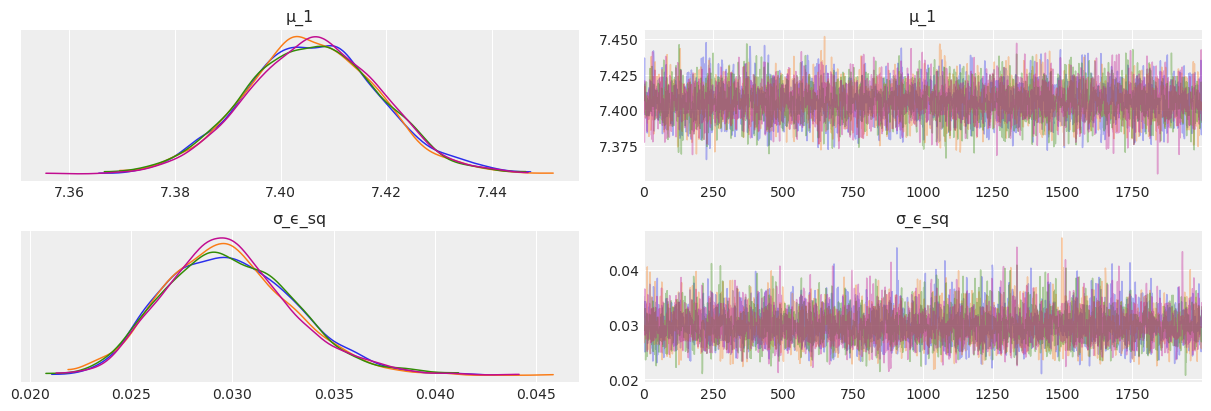

In [74]:
az.plot_trace(trace_det, var_names=['μ_1', 'σ_ϵ_sq']);

In [75]:
az.summary(trace_det, var_names=['μ_1', 'σ_ϵ_sq'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ_1,7.406,0.012,7.382,7.429,0.0,0.0,7067.0,7066.0,7083.0,5472.0,1.0
σ_ϵ_sq,0.030,0.003,0.025,0.036,0.0,0.0,7126.0,7028.0,7161.0,5693.0,1.0


And here we have our parameters. As you can see, we have posterior distributions for our parameters $\mu_1$ and $\sigma_\epsilon^2$, not only a point estimate. Let's compare our results with the statsmodel. For now focus only on the columns mean and sd from the table above. 

Just a quick note on the parameter $\sigma_\epsilon^2$. We've been estimating the variance of the $\epsilon$ term, but when fitting our likelihood we are using the most usuall way to fit a Gaussian distribution, which is with the mean and the standard deviation. That is why I created a `Deterministic` variable (nothing to do with our deterministic model), which is the way to keep track of a transformed variable in `PyMC3`.

# 4. Discussion

Let's follow the same approach that we did in the last post. But first, we need to compare our Bayesian estimation of the parameters with the frequentist approach. Remember that we can solely compare pointwise estimations, since only the Bayesian framework produce posterior distributions.

In [76]:
print(f'statsmodel:\n μ_1 = {model_fit.level["smoothed"][0]:.4f}' +
     f'\n σ_ϵ = {model_fit.params[0]:.4f}')
print(f'bayesian:\n μ_1 = {trace_det["μ_1"].mean():.4f}' +
     f'\n σ_ϵ = {trace_det["σ_ϵ_sq"].mean():.4f}')

statsmodel:
 μ_1 = 7.4061
 σ_ϵ = 0.0294
bayesian:
 μ_1 = 7.4060
 σ_ϵ = 0.0298


Both models yield very similar results. As we saw above this happens because we are using vague priors, which makes the MAP estimations approximate the MLE estimations.

Now, it is time to plot our model fitting against the data and the residuals.

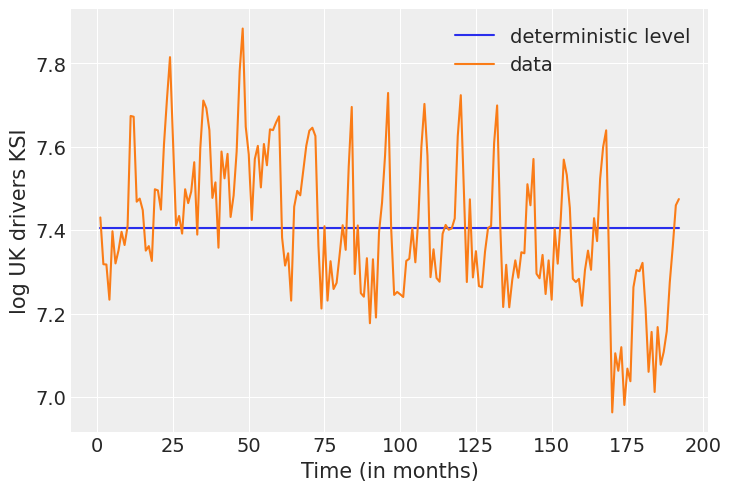

In [55]:
μ_hat_ar = np.ones(len(y)) * μ_hat
plt.plot(t, μ_hat_ar, label='deterministic level')
plt.plot(t, y, label='data')
plt.ylabel('log UK drivers KSI')
plt.xlabel('Time (in months)', rotation=0)
plt.legend();

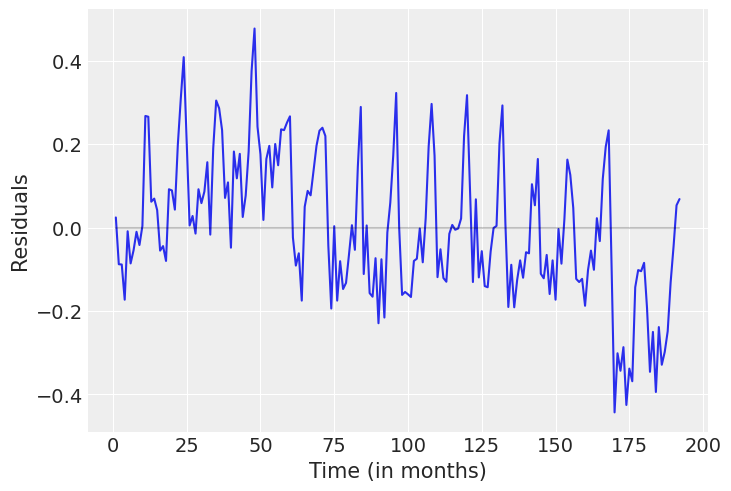

In [56]:
residuals = y - (μ_hat)
plt.plot(t, residuals)
plt.plot(t, np.zeros(len(y)), c='k', alpha=0.2)
plt.ylabel('Residuals')
plt.xlabel('Time (in months)', rotation=0);

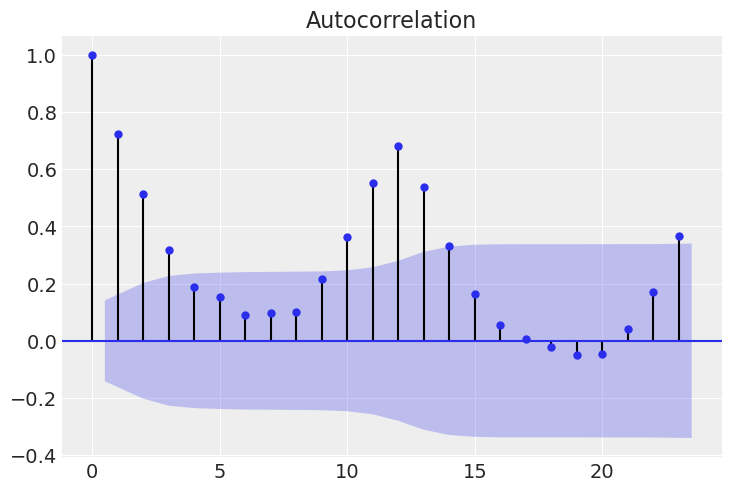

In [79]:
plot_acf(residuals);

Not so exciting! The deterministic level model is constant and thus it does not vary over time as a result. The residuals are clearly not randomly distributed for this case as they are just the result of the deviations of the observed values from their mean.

The correlogram also shows the autocorrelations in the residuals, which we couldn't capture with a deterministic model.

We are not there yet but we've covered an important ground already. 

# 5. Conclusions

We did an important work concerning our understanding of how the estimations of the parameters are performed in both perspectives: frequentist and Bayesian. Using that knowledge, we defined our first state space model from the ground up successfully. Unfortunately, we also saw that it was too simple to capture all the valuable information in our data. As we said in the previous article, there is an underlying dynamic evolution that cannot be observed and we were again unable to model it. 

We are building the momentum and gathering important tools along the way. I think we are ready to start adding some stochastic behaviour to our parameters. See you in the next post!

# References

[1] J. Commandeur, S. Koopman, An Introduction to State Space Time Series Analysis (2007), Oxford University Press